In [1]:
import yfinance as yf

df = yf.Ticker("2330.TW").history(period="10y") #台積電取10年
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-07-01 00:00:00+08:00,79.704177,80.069793,78.972946,78.972946,51539000,0.000000,0.0
2013-07-02 00:00:00+08:00,79.704179,80.435410,79.338563,80.435410,44320000,0.000000,0.0
2013-07-03 00:00:00+08:00,80.435074,80.435074,79.307479,80.435074,44593000,2.999552,0.0
2013-07-04 00:00:00+08:00,80.059209,80.435074,79.683344,80.435074,24252000,0.000000,0.0
2013-07-05 00:00:00+08:00,80.810936,82.314395,80.435071,81.938530,28230000,0.000000,0.0
...,...,...,...,...,...,...,...
2023-06-26 00:00:00+08:00,576.000000,578.000000,574.000000,574.000000,27142262,0.000000,0.0
2023-06-27 00:00:00+08:00,570.000000,575.000000,569.000000,572.000000,21501718,0.000000,0.0
2023-06-28 00:00:00+08:00,579.000000,579.000000,571.000000,574.000000,18175426,0.000000,0.0


In [2]:
df=df.filter(["Close"])
df=df.rename(columns={"Close":"GT"})
df

,GT
Date,
2013-07-01 00:00:00+08:00,78.972946
2013-07-02 00:00:00+08:00,80.435410
2013-07-03 00:00:00+08:00,80.435074
2013-07-04 00:00:00+08:00,80.435074
2013-07-05 00:00:00+08:00,81.938530
...,...
2023-06-26 00:00:00+08:00,574.000000
2023-06-27 00:00:00+08:00,572.000000
2023-06-28 00:00:00+08:00,574.000000


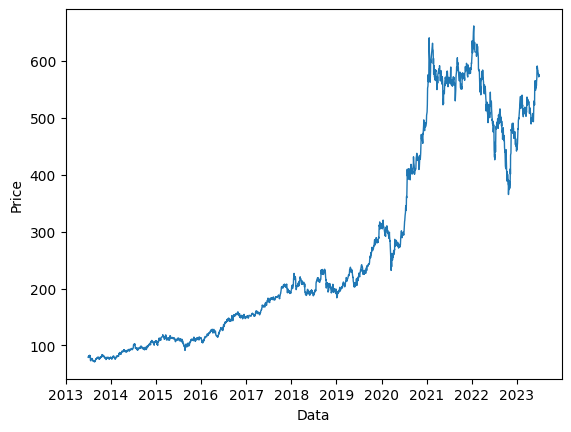

In [3]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn-darkgrid")
plt.xlabel("Data")
plt.ylabel("Price")
plt.plot(df["GT"],linewidth=1)
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
scaled_prices=scaler.fit_transform(df.values)
scaled_prices

array([[0.01356221],
       [0.0160385 ],
       [0.01603793],
       ...,
       [0.85175866],
       [0.85006542],
       [0.85514513]])

# split data,依序取60天為一窗口當作輸入x,輸出為1個y

In [5]:
import numpy as np

MOVING_SIZE=60  #取60天為一窗口當作輸入x,輸出為y

all_x,all_y=[],[]

for i in range (len(scaled_prices)-MOVING_SIZE):
    x=scaled_prices[i:i+MOVING_SIZE]
    y=scaled_prices[i+MOVING_SIZE]
    all_x.append(x)
    all_y.append(y)

all_x,all_y=np.array(all_x),np.array(all_y)
print(all_x.shape)
print(all_y.shape)

(2382, 60, 1)
(2382, 1)


In [6]:
SPLIT=0.8
#把資料分成train,test
train_ds_size=round(all_x.shape[0]*SPLIT)
train_x,train_y=all_x[:train_ds_size],all_y[:train_ds_size]
test_x,test_y=all_x[train_ds_size:],all_y[train_ds_size:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1906, 60, 1)
(1906, 1)
(476, 60, 1)
(476, 1)


# model

In [7]:
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential

model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(train_x.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',loss="mean_squared_error")

# train model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
#把資料分成train,validation
callback=EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)
model.fit(train_x,train_y,validation_split=0.2,callbacks=[callback],epochs=1000)

Epoch 1/1000
48/48 [==============================] - 7s 76ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 2/1000
48/48 [==============================] - 3s 58ms/step - loss: 8.5852e-05 - val_loss: 0.0011
Epoch 3/1000
48/48 [==============================] - 2s 50ms/step - loss: 7.1701e-05 - val_loss: 0.0011
Epoch 4/1000
48/48 [==============================] - 2s 50ms/step - loss: 7.0642e-05 - val_loss: 9.3179e-04
Epoch 5/1000
48/48 [==============================] - 2s 50ms/step - loss: 7.1026e-05 - val_loss: 0.0011
Epoch 6/1000
48/48 [==============================] - 2s 51ms/step - loss: 7.0375e-05 - val_loss: 8.1648e-04
Epoch 7/1000
48/48 [==============================] - 2s 52ms/step - loss: 6.7299e-05 - val_loss: 8.4764e-04
Epoch 8/1000
48/48 [==============================] - 3s 58ms/step - loss: 6.7440e-05 - val_loss: 8.3678e-04
Epoch 9/1000
48/48 [==============================] - 3s 54ms/step - loss: 6.3617e-05 - val_loss: 8.3481e-04
Epoch 10/1000
48/48 [==================

Epoch 76/1000
48/48 [==============================] - 3s 59ms/step - loss: 2.3664e-05 - val_loss: 2.0704e-04
Epoch 77/1000
48/48 [==============================] - 3s 60ms/step - loss: 2.3821e-05 - val_loss: 2.4713e-04
Epoch 78/1000
48/48 [==============================] - 3s 55ms/step - loss: 2.3182e-05 - val_loss: 1.8800e-04
Epoch 79/1000
48/48 [==============================] - 2s 50ms/step - loss: 2.2126e-05 - val_loss: 2.0355e-04
Epoch 80/1000
48/48 [==============================] - 2s 50ms/step - loss: 2.1604e-05 - val_loss: 1.9056e-04
Epoch 81/1000
48/48 [==============================] - 2s 50ms/step - loss: 2.3008e-05 - val_loss: 3.3798e-04
Epoch 82/1000
48/48 [==============================] - 3s 57ms/step - loss: 2.3086e-05 - val_loss: 1.8458e-04
Epoch 83/1000
48/48 [==============================] - 3s 58ms/step - loss: 2.4208e-05 - val_loss: 2.8824e-04
Epoch 84/1000
48/48 [==============================] - 3s 54ms/step - loss: 2.0990e-05 - val_loss: 2.0710e-04
Epoch 85/1

# evaluate model

In [10]:
preds=model.predict(test_x)
preds

15/15 [==============================] - 1s 15ms/step


array([[0.87727726],
       [0.8348991 ],
       [0.8202654 ],
       [0.8226975 ],
       [0.8317448 ],
       [0.84218013],
       [0.83199936],
       [0.82133883],
       [0.82119507],
       [0.820692  ],
       [0.82722527],
       [0.82293475],
       [0.837943  ],
       [0.8460968 ],
       [0.84839433],
       [0.8475727 ],
       [0.83913857],
       [0.8451981 ],
       [0.84041274],
       [0.83798563],
       [0.83187175],
       [0.8235634 ],
       [0.828474  ],
       [0.82979244],
       [0.81302667],
       [0.78678876],
       [0.7750034 ],
       [0.7997055 ],
       [0.8129903 ],
       [0.83224076],
       [0.84644544],
       [0.85325617],
       [0.86171526],
       [0.87631285],
       [0.87549955],
       [0.8644475 ],
       [0.8850881 ],
       [0.90633816],
       [0.8932932 ],
       [0.8832279 ],
       [0.88386774],
       [0.890216  ],
       [0.87932   ],
       [0.8744975 ],
       [0.86530274],
       [0.8581026 ],
       [0.85850257],
       [0.836

In [11]:
preds=scaler.inverse_transform(preds)
preds
#轉成真實股價

array([[589.0709 ],
       [564.04297],
       [555.4005 ],
       [556.8369 ],
       [562.18005],
       [568.3431 ],
       [562.33044],
       [556.0345 ],
       [555.9496 ],
       [555.65247],
       [559.5109 ],
       [556.977  ],
       [565.84064],
       [570.6562 ],
       [572.01306],
       [571.52783],
       [566.54675],
       [570.1254 ],
       [567.29926],
       [565.86584],
       [562.25507],
       [557.34827],
       [560.2484 ],
       [561.02704],
       [551.1254 ],
       [535.6297 ],
       [528.6694 ],
       [543.2581 ],
       [551.10394],
       [562.473  ],
       [570.86206],
       [574.8844 ],
       [579.8802 ],
       [588.50134],
       [588.021  ],
       [581.49384],
       [593.6839 ],
       [606.2339 ],
       [598.5297 ],
       [592.58527],
       [592.9632 ],
       [596.7124 ],
       [590.27734],
       [587.4292 ],
       [581.99896],
       [577.74664],
       [577.98285],
       [564.70465],
       [565.6186 ],
       [576.6886 ],


<function matplotlib.pyplot.show(close=None, block=None)>

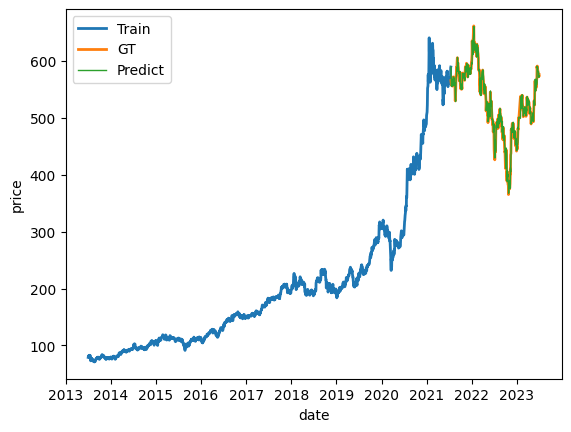

In [12]:
# MOVING_SIZE=60

train_df=df[:train_ds_size + MOVING_SIZE]
test_df=df[train_ds_size + MOVING_SIZE:]
test_df=test_df.assign(Predict=preds)

plt.xlabel("date")
plt.ylabel("price")
plt.plot(train_df["GT"],linewidth=2)
plt.plot(test_df["GT"],linewidth=2)
plt.plot(test_df["Predict"],linewidth=1)
plt.legend(["Train","GT","Predict"])
plt.show

# check

<function matplotlib.pyplot.show(close=None, block=None)>

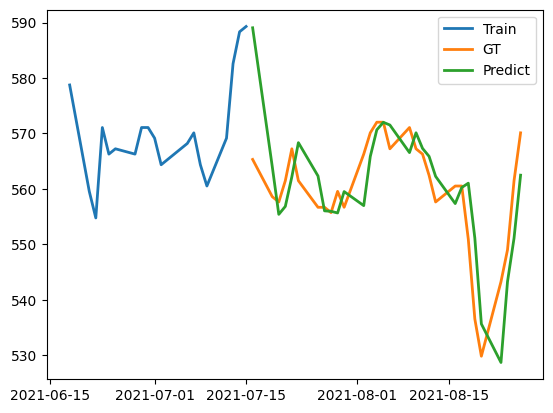

In [13]:
plt.plot(train_df["GT"][-20:],linewidth=2)
plt.plot(test_df["GT"][:30],linewidth=2)
plt.plot(test_df["Predict"][:30],linewidth=2)
plt.legend(["Train","GT","Predict"])
plt.show

#predict疑似只是把真實股價平移

In [14]:
check_df=test_df.assign(Shifted=test_df["GT"].shift(1))
check_df.iat[0,-1]=train_df.iat[-1,-1]
check_df

,GT,Predict,Shifted
Date,,,
2021-07-16 00:00:00+08:00,565.313904,589.070923,589.308472
2021-07-19 00:00:00+08:00,558.595276,564.042969,565.313904
2021-07-20 00:00:00+08:00,557.635559,555.400513,558.595276
2021-07-21 00:00:00+08:00,561.474609,556.836914,557.635559
2021-07-22 00:00:00+08:00,567.233398,562.180054,561.474609
...,...,...,...
2023-06-26 00:00:00+08:00,574.000000,580.632324,581.000000
2023-06-27 00:00:00+08:00,572.000000,573.676941,574.000000
2023-06-28 00:00:00+08:00,574.000000,571.294189,572.000000


In [15]:
from sklearn.metrics import mean_squared_error

pred_rmse=mean_squared_error(check_df["GT"],check_df["Predict"],squared=False)
pred_cvrmse=pred_rmse/ check_df["GT"].mean()*100
pred_cvrmse


1.6904432192742787

In [16]:
shift_rmse=mean_squared_error(check_df["GT"],check_df["Shifted"],squared=False)
shift_cvrmse=shift_rmse/ check_df["GT"].mean()*100
shift_cvrmse

1.6775756920092737